<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Single Layer Neural Network with Time Series Data

Now that you've seen statistical methods in the previous week, you will now shift to using neural networks to build your prediction models. You will start with a simple network in this notebook and move on to more complex architectures in the next weeks. By the end of this lab, you will be able to:

* build a single layer network and train it using the same synthetic data you used in the previous lab
* prepare time series data for training and evaluation
* measure the performance of your model against a validation set

## Imports

You will first import the packages you will need to execute all the code in this lab. You will use:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) to build your model and prepare data windows
* [Numpy](https://numpy.org/) for numerical processing
* and Matplotlib's [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) library for visualization

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will then define some utility functions that you also saw in the previous labs. These will take care of visualizing your time series data and model predictions, as well as generating the synthetic data.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

The code below generates the same synthetic data you used in the previous lab. It will contain 1,461 data points that has trend, seasonality, and noise.

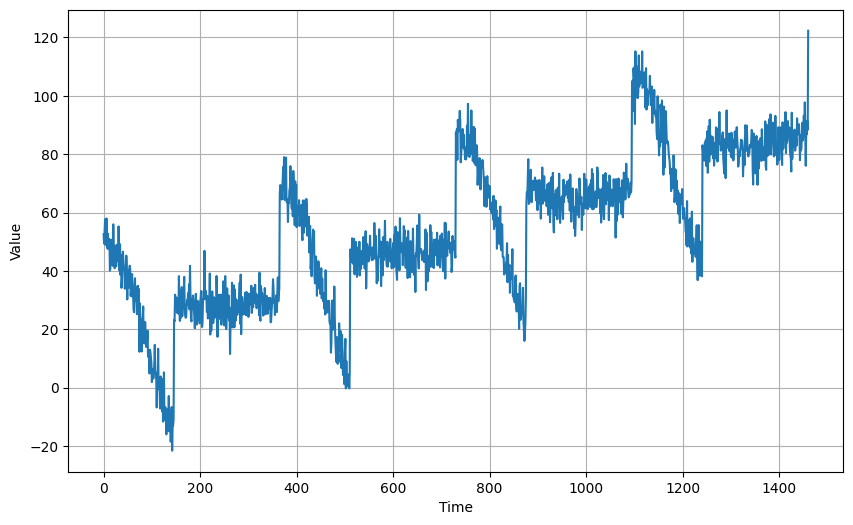

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation,

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

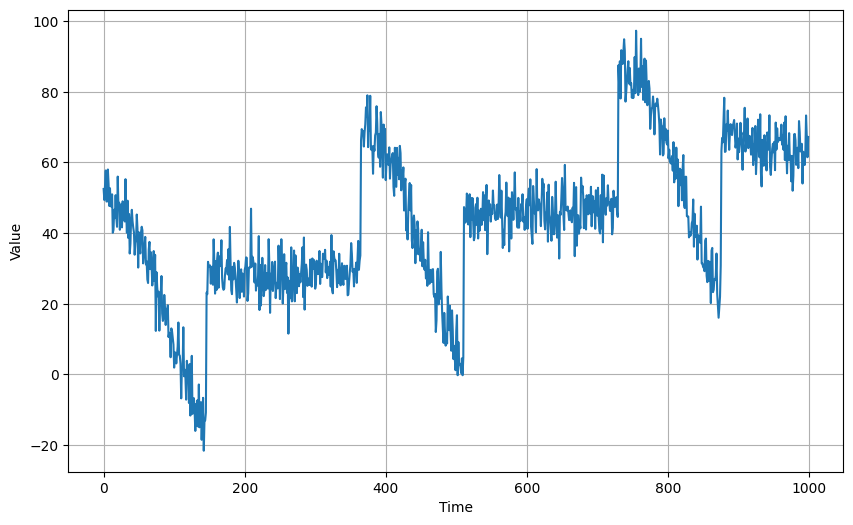

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

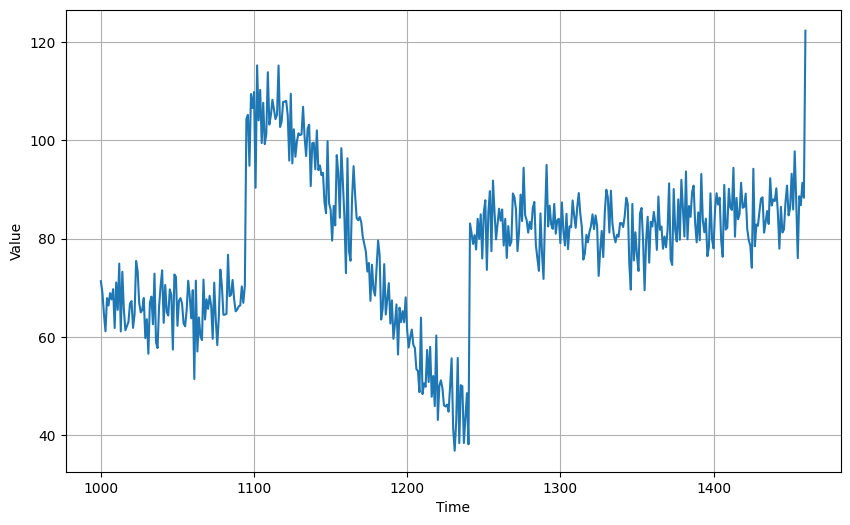

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

## Prepare features and labels

You will then prepare your data windows as shown in the previous lab. It is good to declare parameters in a separate cell so you can easily tweak it later if you want.

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

The following function contains all the preprocessing steps you did in the previous lab. This makes it modular so you can easily use it in your other projects if needed.

One thing to note here is the `window_size + 1` when you call `dataset.window()`. There is a `+ 1` to indicate that you're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

Now you can generate the dataset windows from the train set.

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

You can again inspect the output to see if the function is behaving as expected. The code below will use the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method of the `tf.data.Dataset` API to grab a single batch. It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [ ]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below. You will assign the layer to a variable `l0` so you can also look at the final weights later using the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method.

In [ ]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.15076277],
       [-0.39754948],
       [-0.10526487],
       [ 0.01408261],
       [-0.07965374],
       [-0.02463216],
       [ 0.36226207],
       [-0.3520066 ],
       [-0.53416526],
       [ 0.04349542],
       [-0.43765652],
       [ 0.21992755],
       [ 0.22749358],
       [-0.22784695],
       [ 0.20802975],
       [ 0.06214452],
       [-0.11749658],
       [ 0.14982533],
       [-0.30707595],
       [ 0.02258211]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You will set [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) as the loss function and use [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) to optimize the weights during training.

In [ ]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Train the Model

Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [ ]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 2204.4644
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 167.6611
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 94.5343
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 88.7909
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 85.8661
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 83.3061
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 80.7076
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 78.2089
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 76.7736
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 74.3810
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 74.4764
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 72.0201
Epoch 13/100
31/31 [=

You can see the final weights by again calling the `get_weights()` method.

In [ ]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.02449199],
       [-0.05177878],
       [ 0.04679186],
       [ 0.00522955],
       [ 0.00272157],
       [ 0.00358649],
       [ 0.06279884],
       [-0.02682937],
       [-0.07847905],
       [ 0.0597654 ],
       [-0.07068083],
       [ 0.04613996],
       [-0.0086454 ],
       [-0.01204365],
       [ 0.03899367],
       [ 0.07238141],
       [ 0.00783843],
       [ 0.20092171],
       [ 0.21963851],
       [ 0.4627601 ]], dtype=float32), array([0.01819371], dtype=float32)]


## Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [ ]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 93ms/step
model prediction: [[43.389393]]


To compute the metrics, you will want to generate model predictions for your validation set. Remember that this set refers to points at index `1000` to `1460` of the entire series. You will need to code the steps to generate those from your model. The cell below demonstrates one way of doing that.

Basically, it feeds the entire series to your model 20 points at a time and append all results to a `forecast` list. It will then slice the points that corresponds to the validation set.

The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.*

In [ ]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 22ms/step
length of the forecast list: 461
shape of the validation set: (461,)


To visualize the results, you will need to convert the predictions to a form that the `plot_series()` utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes.

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


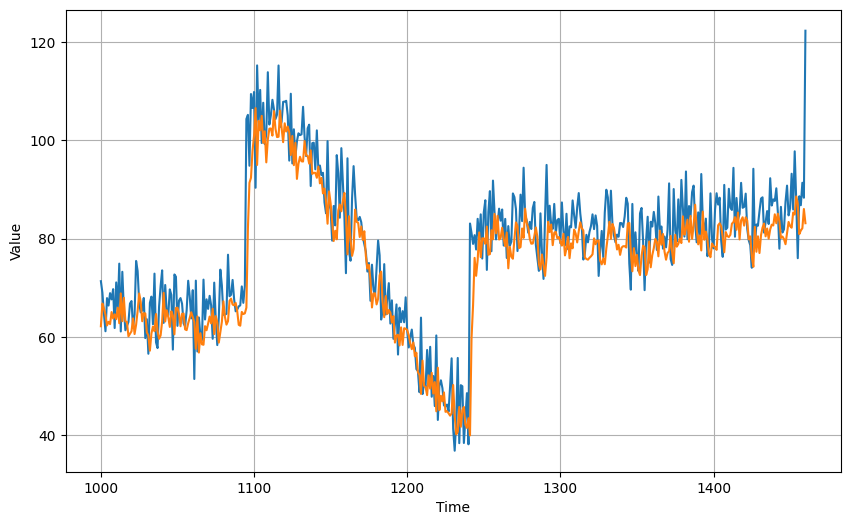

In [ ]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

You can compute the metrics by calling the same functions as before. You will get an MAE close to 5.

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

57.47002
5.592625


## RNN

## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`.

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 18ms/step


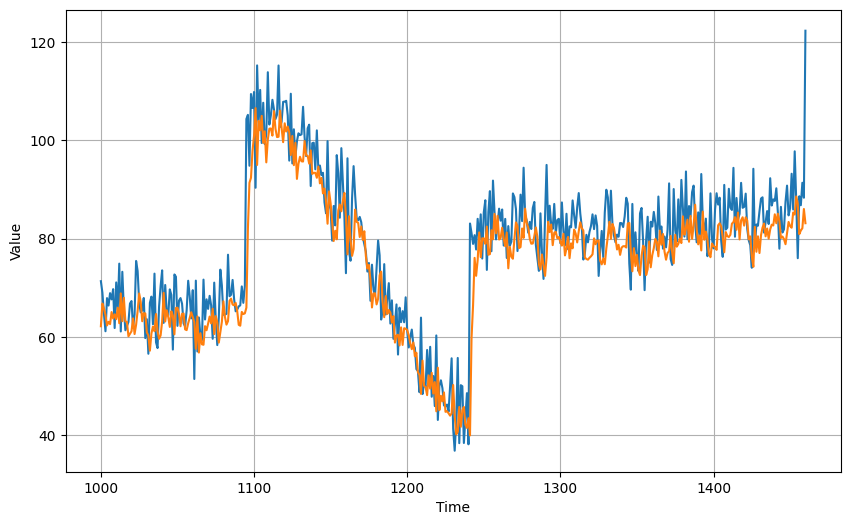

In [ ]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

57.470016
5.592625


### LSTM

In [ ]:
# Build the Model
model_LSTMtune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 25ms/step - loss: 54.2761 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 53.9074 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 9ms/step - loss: 53.4614 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 13ms/step - loss: 52.9617 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 52.4007 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 51.7740 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 51.0728 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 50.2889 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 49.4113 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 48.4343 - lr: 2.8184e-08
Epoch 11/100
3

(1e-08, 0.001, 0.0, 30.0)

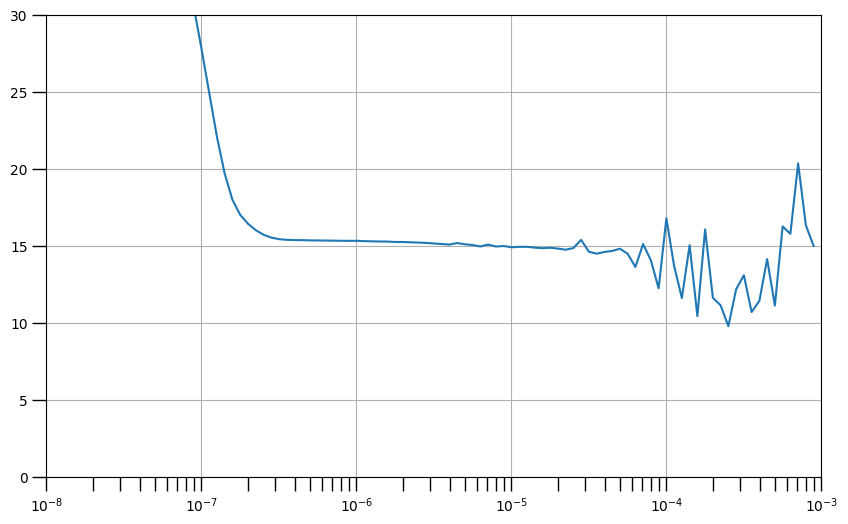

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

You can then proceed to train the model with your chosen learning rate.

Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the clear_session() method to declutter memory used by Keras. This is added in the first line below.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 12s 40ms/step - loss: 28.1401 - mae: 28.6361
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 12.4014 - mae: 12.8948
Epoch 3/100
31/31 [==============================] - 1s 39ms/step - loss: 7.7527 - mae: 8.2362
Epoch 4/100
31/31 [==============================] - 3s 78ms/step - loss: 6.1079 - mae: 6.5902
Epoch 5/100
31/31 [==============================] - 3s 70ms/step - loss: 5.6542 - mae: 6.1348
Epoch 6/100
31/31 [==============================] - 2s 75ms/step - loss: 5.5499 - mae: 6.0326
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 5.3673 - mae: 5.8445
Epoch 8/100
31/31 [==============================] - 1s 39ms/step - loss: 5.2576 - mae: 5.7370
Epoch 9/100
31/31 [==============================] - 2s 50ms/step - loss: 5.2753 - mae: 5.7536
Epoch 10/100
31/31 [==============================] - 1s 40ms/step - loss: 5.1959 - mae: 5.6762
Epoch 11/100
31/31 [========================

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 2s 15ms/step


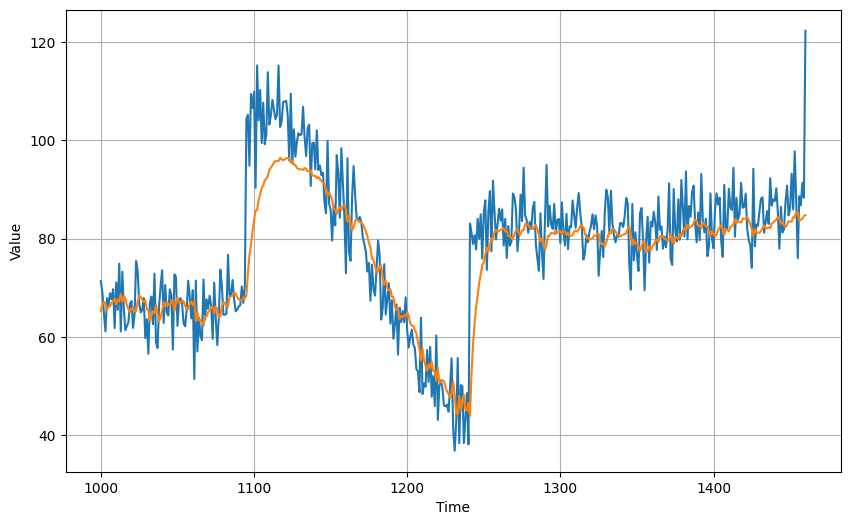

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

60.327774
5.574097


### Conv1D - LSTM

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 8s 54ms/step - loss: 10.7317 - mae: 11.2210
Epoch 2/500
31/31 [==============================] - 1s 40ms/step - loss: 9.3800 - mae: 9.8613
Epoch 3/500
31/31 [==============================] - 1s 39ms/step - loss: 8.9378 - mae: 9.4192
Epoch 4/500
31/31 [==============================] - 1s 38ms/step - loss: 8.6231 - mae: 9.1054
Epoch 5/500
31/31 [==============================] - 1s 40ms/step - loss: 8.3367 - mae: 8.8182
Epoch 6/500
31/31 [==============================] - 1s 40ms/step - loss: 8.1598 - mae: 8.6389
Epoch 7/500
31/31 [==============================] - 2s 53ms/step - loss: 7.9677 - mae: 8.4511
Epoch 8/500
31/31 [==============================] - 1s 37ms/step - loss: 7.8180 - mae: 8.3004
Epoch 9/500
31/31 [==============================] - 1s 40ms/step - loss: 7.6231 - mae: 8.1054
Epoch 10/500
31/31 [==============================] - 1s 37ms/step - loss: 7.3858 - mae: 7.8652
Epoch 11/500
31/31 [===========================

In [ ]:
def plot_series_adv(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 1s 15ms/step


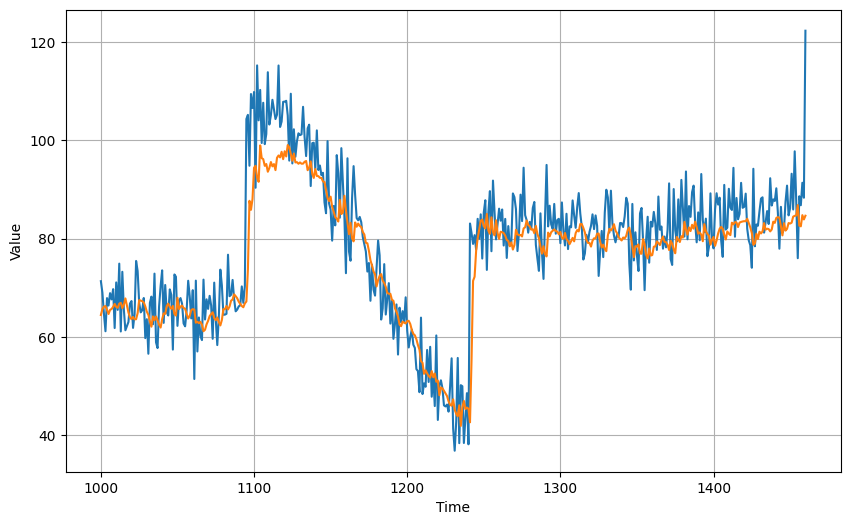

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

52.734856
5.306548


### Add Val Set and Early CallBack

In [ ]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

In [ ]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
31/31 [==============================] - 10s 88ms/step - loss: 4.1194 - mae: 4.5942 - val_loss: 4.8892 - val_mae: 5.3687
Epoch 2/500
31/31 [==============================] - 2s 48ms/step - loss: 4.1211 - mae: 4.5937 - val_loss: 5.0593 - val_mae: 5.5431
Epoch 3/500
31/31 [==============================] - 2s 47ms/step - loss: 4.1450 - mae: 4.6209 - val_loss: 5.1709 - val_mae: 5.6572
Epoch 4/500
31/31 [==============================] - 3s 101ms/step - loss: 4.1175 - mae: 4.5921 - val_loss: 4.7699 - val_mae: 5.2500
Epoch 5/500
31/31 [==============================] - 2s 48ms/step - loss: 4.1303 - mae: 4.6031 - val_loss: 4.9088 - val_mae: 5.3882
Epoch 6/500
31/31 [==============================] - ETA: 0s - loss: 4.1202 - mae: 4.5959
Required val MAE is met so cancelling training!
31/31 [==============================] - 1s 43ms/step - loss: 4.1202 - mae: 4.5959 - val_loss: 4.6431 - val_mae: 5.1177


15/15 [==============================] - 2s 15ms/step


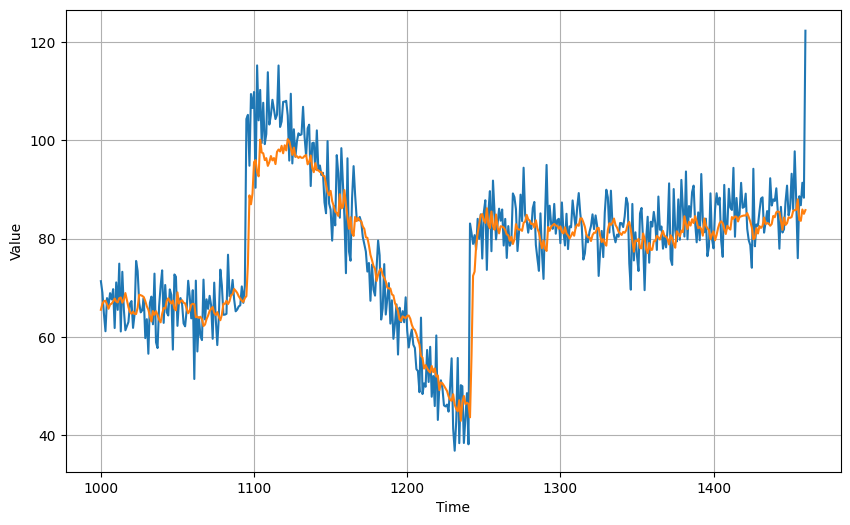

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

48.108997
5.060067
